In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from SPNO_1d import *

In [2]:
x_data = np.load('data/spde_2_x.npy')
y_data = np.load('data/spde_2_y.npy')

In [3]:
x_grid = np.linspace(-1, 1, x_data.shape[-1])

ntrain = 900
ntest = 100

batch_size = 50
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

x_train = x_data[:ntrain,::5]
y_train = y_data[:ntrain,::5]
x_test = x_data[-ntest:,::5]
y_test = y_data[-ntest:,::5]
x_grid = x_grid[::5]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = SPNO1d(modes, width, 1/2**4, x_grid.shape[-1], x_grid[0], x_grid[-1]).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 1464842
epoch 1/500 L2 = 0.999925, MSE = 773832.315972, using 3.553992s
epoch 2/500 L2 = 0.955684, MSE = 747365.758681, using 0.631699s
epoch 3/500 L2 = 0.846176, MSE = 644972.501736, using 0.637743s
epoch 4/500 L2 = 0.538474, MSE = 206845.143229, using 0.611441s
epoch 5/500 L2 = 0.293192, MSE = 158043.305013, using 0.633906s
epoch 6/500 L2 = 0.183446, MSE = 16023.373183, using 0.612712s
epoch 7/500 L2 = 0.127264, MSE = 6323.383219, using 0.620565s
epoch 8/500 L2 = 0.158023, MSE = 4291.148263, using 0.614031s
epoch 9/500 L2 = 0.074371, MSE = 1594.004057, using 0.614555s
epoch 10/500 L2 = 0.074026, MSE = 1847.409916, using 0.621500s
epoch 11/500 L2 = 0.052100, MSE = 771.162240, using 0.636739s
epoch 12/500 L2 = 0.092268, MSE = 2769.832879, using 0.624852s
epoch 13/500 L2 = 0.039582, MSE = 1836.291122, using 0.619999s
epoch 14/500 L2 = 0.062910, MSE = 2547.912793, using 0.614901s
epoch 15/500 L2 = 0.040826, MSE = 795.412866, using 0.619154s
epoch 16/500 L2 = 0.050486, M

epoch 133/500 L2 = 0.006347, MSE = 20.806625, using 0.616307s
epoch 134/500 L2 = 0.010474, MSE = 15.937871, using 0.630997s
epoch 135/500 L2 = 0.013304, MSE = 17.343067, using 0.620967s
epoch 136/500 L2 = 0.013635, MSE = 37.580928, using 0.627370s
epoch 137/500 L2 = 0.015445, MSE = 89.183418, using 0.604073s
epoch 138/500 L2 = 0.012566, MSE = 92.545125, using 0.614789s
epoch 139/500 L2 = 0.007688, MSE = 24.397893, using 0.634718s
epoch 140/500 L2 = 0.012722, MSE = 15.156137, using 0.617840s
epoch 141/500 L2 = 0.012410, MSE = 55.238179, using 0.628219s
epoch 142/500 L2 = 0.009623, MSE = 53.142606, using 0.627784s
epoch 143/500 L2 = 0.015595, MSE = 23.767181, using 0.634746s
epoch 144/500 L2 = 0.011318, MSE = 14.442415, using 0.644597s
epoch 145/500 L2 = 0.016110, MSE = 17.221176, using 0.619300s
epoch 146/500 L2 = 0.024144, MSE = 17.126498, using 0.625268s
epoch 147/500 L2 = 0.020348, MSE = 28.998872, using 0.635421s
epoch 148/500 L2 = 0.019914, MSE = 28.405338, using 0.637889s
epoch 14

epoch 267/500 L2 = 0.002751, MSE = 0.374023, using 0.614731s
epoch 268/500 L2 = 0.001488, MSE = 0.434629, using 0.624618s
epoch 269/500 L2 = 0.001309, MSE = 0.454272, using 0.626322s
epoch 270/500 L2 = 0.000847, MSE = 0.135252, using 0.629484s
epoch 271/500 L2 = 0.001510, MSE = 0.203156, using 0.488489s
epoch 272/500 L2 = 0.001464, MSE = 0.190319, using 0.448119s
epoch 273/500 L2 = 0.001282, MSE = 0.187151, using 0.372837s
epoch 274/500 L2 = 0.001964, MSE = 0.586808, using 0.370051s
epoch 275/500 L2 = 0.002509, MSE = 0.825626, using 0.373128s
epoch 276/500 L2 = 0.002514, MSE = 0.642782, using 0.375286s
epoch 277/500 L2 = 0.002394, MSE = 0.333822, using 0.368574s
epoch 278/500 L2 = 0.001275, MSE = 0.534211, using 0.371109s
epoch 279/500 L2 = 0.001400, MSE = 0.783172, using 0.367340s
epoch 280/500 L2 = 0.001359, MSE = 1.796088, using 0.366928s
epoch 281/500 L2 = 0.001377, MSE = 1.418170, using 0.366410s
epoch 282/500 L2 = 0.001272, MSE = 0.685543, using 0.365502s
epoch 283/500 L2 = 0.001

epoch 402/500 L2 = 0.000526, MSE = 0.075081, using 0.375826s
epoch 403/500 L2 = 0.000559, MSE = 0.081362, using 0.374617s
epoch 404/500 L2 = 0.000491, MSE = 0.074650, using 0.370208s
epoch 405/500 L2 = 0.000547, MSE = 0.086603, using 0.370979s
epoch 406/500 L2 = 0.000506, MSE = 0.080579, using 0.372415s
epoch 407/500 L2 = 0.000506, MSE = 0.079045, using 0.369263s
epoch 408/500 L2 = 0.000527, MSE = 0.077573, using 0.376548s
epoch 409/500 L2 = 0.000490, MSE = 0.080446, using 0.373688s
epoch 410/500 L2 = 0.000474, MSE = 0.075516, using 0.375231s
epoch 411/500 L2 = 0.000473, MSE = 0.075291, using 0.374587s
epoch 412/500 L2 = 0.000499, MSE = 0.079941, using 0.369585s
epoch 413/500 L2 = 0.000485, MSE = 0.084826, using 0.392637s
epoch 414/500 L2 = 0.000493, MSE = 0.083405, using 0.395505s
epoch 415/500 L2 = 0.000563, MSE = 0.084949, using 0.387359s
epoch 416/500 L2 = 0.000613, MSE = 0.084119, using 0.389519s
epoch 417/500 L2 = 0.000544, MSE = 0.086322, using 0.392223s
epoch 418/500 L2 = 0.000

In [4]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.00044408071924408434 , MSE = 0.04870781481673475


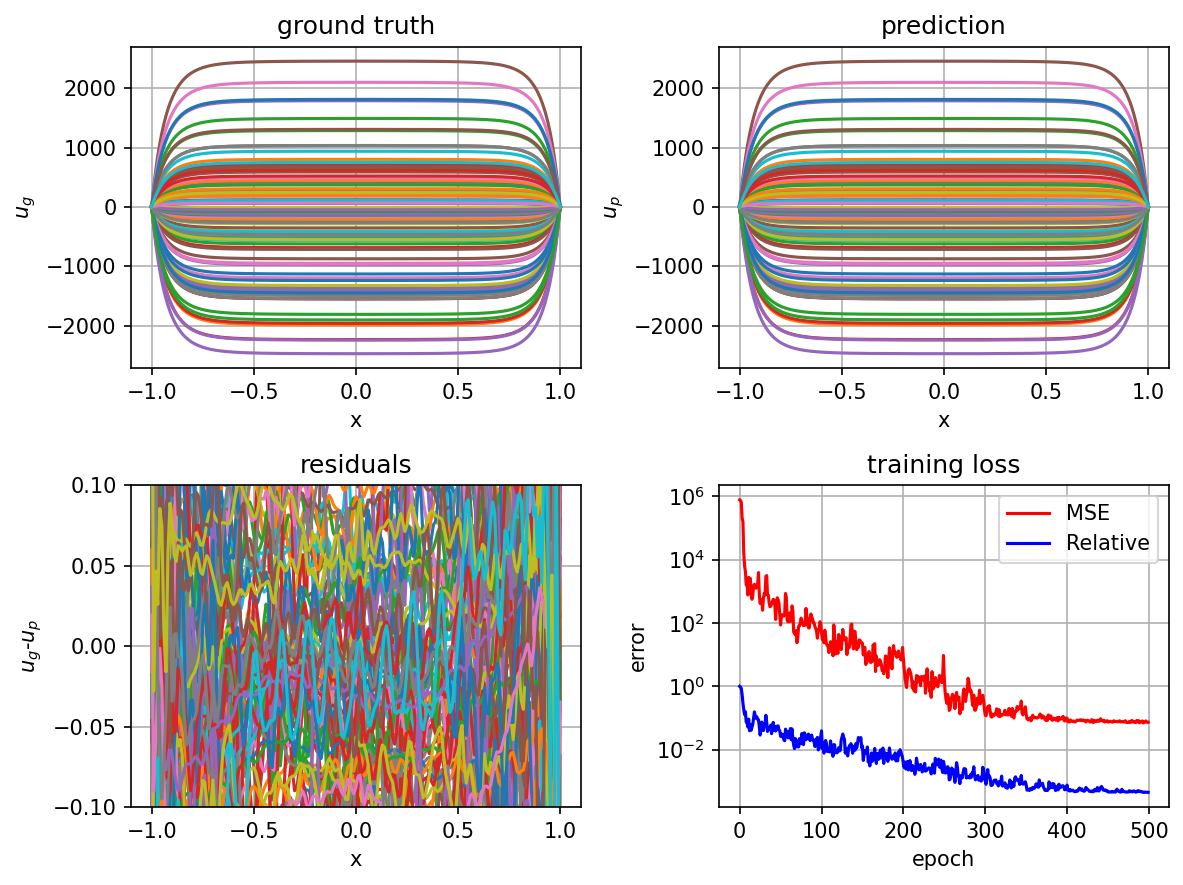

In [5]:
residual = pred-y_test
fig = plt.figure(figsize=(8,6),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
for i in range(ntest):
    plt.plot(x_grid,y_test[i])
plt.xlabel("x")
plt.ylabel("$u_g$")
plt.grid()

plt.subplot(2,2,2)
plt.title("prediction")
for i in range(ntest):
    plt.plot(x_grid,pred[i])
plt.xlabel("x")
plt.ylabel("$u_p$")
plt.grid()

plt.subplot(2,2,3)
plt.title("residuals")
plt.ylim([-0.1,0.1])
for i in range(ntest):
    plt.plot(x_grid,residual[i])
plt.xlabel("x")
plt.ylabel("$u_g$-$u_p$")
plt.grid()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

In [6]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(0.0042) tensor(0.0204)


In [7]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/spno_loss_2.npy",loss)
torch.save(model,"model/spno_2")